In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Propose(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Propose(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/26/2019 21:25:53 ELBO=-4.36209656e+02 at epoch 1
02/26/2019 21:25:53 ELBO=-4.29295258e+02 at epoch 2
02/26/2019 21:25:54 ELBO=-4.42137207e+02 at epoch 3
02/26/2019 21:25:54 ELBO=-4.45637512e+02 at epoch 4
02/26/2019 21:25:54 ELBO=-4.24284180e+02 at epoch 5
02/26/2019 21:25:54 ELBO=-4.24492249e+02 at epoch 6
02/26/2019 21:25:55 ELBO=-4.36660889e+02 at epoch 7
02/26/2019 21:25:55 ELBO=-4.15711975e+02 at epoch 8
02/26/2019 21:25:55 ELBO=-4.30255219e+02 at epoch 9
02/26/2019 21:25:56 ELBO=-4.26558411e+02 at epoch 10
02/26/2019 21:25:56 ELBO=-4.24192657e+02 at epoch 11
02/26/2019 21:25:56 ELBO=-4.13093079e+02 at epoch 12
02/26/2019 21:25:57 ELBO=-4.24746399e+02 at epoch 13
02/26/2019 21:25:57 ELBO=-4.14356537e+02 at epoch 14
02/26/2019 21:25:57 ELBO=-4.02670135e+02 at epoch 15
02/26/2019 21:25:58 ELBO=-4.17401672e+02 at epoch 16
02/26/2019 21:25:58 ELBO=-4.00355316e+02 at epoch 17
02/26/2019 21:25:58 ELBO=-3.96859558e+02 at epoch 18
02/26/2019 21:25:58 ELBO=-3.94433990e+02 at epoch 19
02

Epoch   352: reducing learning rate of group 0 to 5.0000e-02.


02/26/2019 21:28:16 ELBO=-1.31247543e+02 at epoch 354
02/26/2019 21:28:17 ELBO=-1.31603638e+02 at epoch 355
02/26/2019 21:28:17 ELBO=-1.25986931e+02 at epoch 356
02/26/2019 21:28:18 ELBO=-1.25899330e+02 at epoch 357
02/26/2019 21:28:18 ELBO=-1.22891563e+02 at epoch 358
02/26/2019 21:28:18 ELBO=-1.40086380e+02 at epoch 359
02/26/2019 21:28:19 ELBO=-1.30765549e+02 at epoch 360
02/26/2019 21:28:19 ELBO=-1.20208229e+02 at epoch 361
02/26/2019 21:28:19 ELBO=-1.32971710e+02 at epoch 362
02/26/2019 21:28:20 ELBO=-1.33326630e+02 at epoch 363
02/26/2019 21:28:20 ELBO=-1.15695396e+02 at epoch 364
02/26/2019 21:28:21 ELBO=-1.27239708e+02 at epoch 365
02/26/2019 21:28:21 ELBO=-1.23062355e+02 at epoch 366
02/26/2019 21:28:21 ELBO=-1.37766800e+02 at epoch 367
02/26/2019 21:28:22 ELBO=-1.14678474e+02 at epoch 368
02/26/2019 21:28:23 ELBO=-1.25030647e+02 at epoch 369
02/26/2019 21:28:23 ELBO=-1.19131920e+02 at epoch 370
02/26/2019 21:28:24 ELBO=-1.24748344e+02 at epoch 371
02/26/2019 21:28:24 ELBO=-1.

Epoch   588: reducing learning rate of group 0 to 2.5000e-02.


02/26/2019 21:29:50 ELBO=-1.06159355e+02 at epoch 590
02/26/2019 21:29:51 ELBO=-1.01646912e+02 at epoch 591
02/26/2019 21:29:51 ELBO=-1.04806870e+02 at epoch 592
02/26/2019 21:29:51 ELBO=-9.79197693e+01 at epoch 593
02/26/2019 21:29:52 ELBO=-1.05691803e+02 at epoch 594
02/26/2019 21:29:52 ELBO=-9.90475464e+01 at epoch 595
02/26/2019 21:29:52 ELBO=-9.37474823e+01 at epoch 596
02/26/2019 21:29:53 ELBO=-9.18267899e+01 at epoch 597
02/26/2019 21:29:53 ELBO=-9.05317993e+01 at epoch 598
02/26/2019 21:29:53 ELBO=-8.51032181e+01 at epoch 599
02/26/2019 21:29:54 ELBO=-8.98734436e+01 at epoch 600
02/26/2019 21:29:54 ELBO=-9.05545044e+01 at epoch 601
02/26/2019 21:29:54 ELBO=-8.51443253e+01 at epoch 602
02/26/2019 21:29:55 ELBO=-8.30841293e+01 at epoch 603
02/26/2019 21:29:55 ELBO=-8.26240005e+01 at epoch 604
02/26/2019 21:29:55 ELBO=-9.46618347e+01 at epoch 605
02/26/2019 21:29:56 ELBO=-8.68686905e+01 at epoch 606
02/26/2019 21:29:56 ELBO=-1.02412819e+02 at epoch 607
02/26/2019 21:29:57 ELBO=-9.

Epoch   814: reducing learning rate of group 0 to 1.2500e-02.


02/26/2019 21:31:10 ELBO=-7.77572021e+01 at epoch 816
02/26/2019 21:31:10 ELBO=-8.37814102e+01 at epoch 817
02/26/2019 21:31:11 ELBO=-7.62768326e+01 at epoch 818
02/26/2019 21:31:11 ELBO=-8.45438156e+01 at epoch 819
02/26/2019 21:31:11 ELBO=-8.93597717e+01 at epoch 820
02/26/2019 21:31:12 ELBO=-7.83433762e+01 at epoch 821
02/26/2019 21:31:12 ELBO=-8.14671936e+01 at epoch 822
02/26/2019 21:31:12 ELBO=-8.35058594e+01 at epoch 823
02/26/2019 21:31:13 ELBO=-7.03089142e+01 at epoch 824
02/26/2019 21:31:13 ELBO=-7.72530823e+01 at epoch 825
02/26/2019 21:31:13 ELBO=-7.84517899e+01 at epoch 826
02/26/2019 21:31:14 ELBO=-8.27307053e+01 at epoch 827
02/26/2019 21:31:14 ELBO=-8.67807007e+01 at epoch 828
02/26/2019 21:31:14 ELBO=-9.02397995e+01 at epoch 829
02/26/2019 21:31:15 ELBO=-7.36353149e+01 at epoch 830
02/26/2019 21:31:15 ELBO=-7.39819107e+01 at epoch 831
02/26/2019 21:31:15 ELBO=-9.40027161e+01 at epoch 832
02/26/2019 21:31:16 ELBO=-7.16986465e+01 at epoch 833
02/26/2019 21:31:16 ELBO=-8.

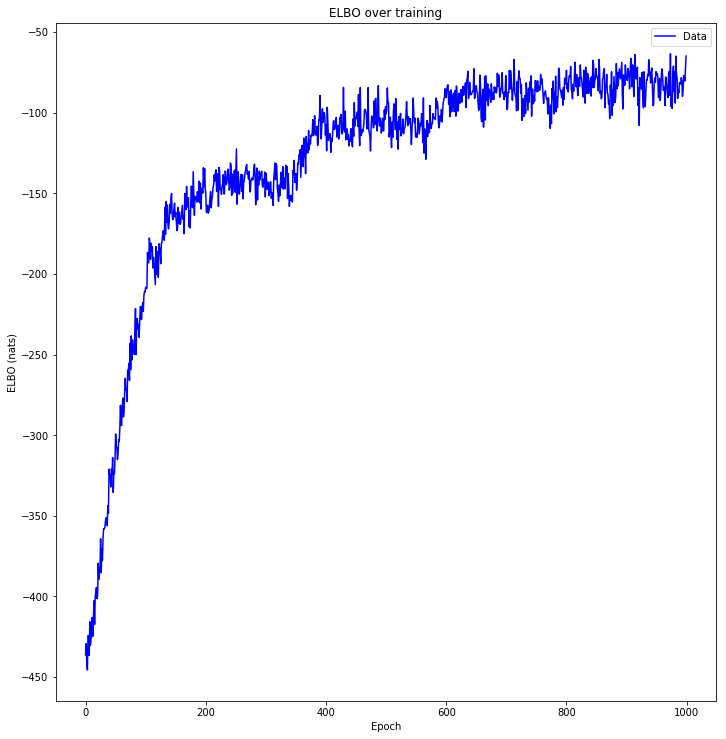

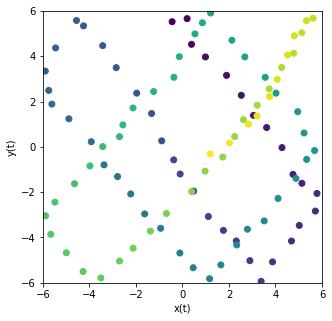

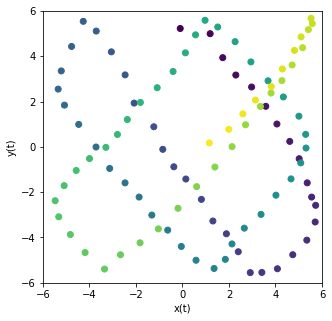

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.8118, -1.8516], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.5189, -2.5280], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.4111,  0.0000],\n        [-0.0871, -1.3547]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-0.2353,  5.4104], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.2524, -1.2028], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.4701, -2.1701], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 0.3168, -1.0259],\n        [ 0.5258, -0.6926],\n        [ 0.7981, -0.7740],\n        [ 0.6526, -0.8676],\n        [ 0.5529, -0.8139],\n        [ 0.5530, -0.6612],\n        [ 0.5961, -0.8649],\n        [ 0.4963, -1.0333],\n        [ 0.4789, -0.4625],\n        [ 0.5669, -0.5400],\n        [ 0.5029, -0.7503],\n        [-0.5599, -0.6772],\n        [-0.4753, -0.7023],\n        [-0.6594, -0.8925],\n        [-0.5195, -1.2363],\n        [-0.5292, -0.9136],\n        [-0.5609,  0.8715],\n

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([-0.4446,  5.5271])
Inferred position at time 0 tensor([-0.0956,  5.2281])
MSE at time 0 tensor(0.2112)
Position at time 1 tensor([0.2000, 5.6630])
Inferred position at time 1 tensor([1.1905, 4.9985])
MSE at time 1 tensor(1.4225)
Position at time 2 tensor([0.3889, 4.5288])
Inferred position at time 2 tensor([1.7330, 3.9404])
MSE at time 2 tensor(2.1528)
Position at time 3 tensor([0.9891, 3.9721])
Inferred position at time 3 tensor([2.2954, 3.1731])
MSE at time 3 tensor(2.3450)
Position at time 4 tensor([1.8970, 3.1586])
Inferred position at time 4 tensor([2.9744, 2.6439])
MSE at time 4 tensor(1.4258)
Position at time 5 tensor([2.5312, 2.2781])
Inferred position at time 5 tensor([3.5846, 1.7917])
MSE at time 5 tensor(1.3462)
Position at time 6 tensor([3.0564, 1.3931])
Inferred position at time 6 tensor([4.0630, 1.0109])
MSE at time 6 tensor(1.1594)
Position at time 7 tensor([3.6209, 0.8550])
Inferred position at time 7 tensor([4.6153, 0.2433])
MSE at time 7 ten

In [24]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Inferred position at time 0 tensor([-0.2122,  5.3371])
MSE at time 0 tensor(0.0901)
Inferred position at time 1 tensor([-0.5045,  5.1140])
MSE at time 1 tensor(0.7978)
Inferred position at time 2 tensor([-0.0982,  4.1593])
MSE at time 2 tensor(0.3739)
Inferred position at time 3 tensor([0.5874, 3.3348])
MSE at time 3 tensor(0.5675)
Inferred position at time 4 tensor([1.3728, 2.6248])
MSE at time 4 tensor(0.5596)
Inferred position at time 5 tensor([2.0445, 1.7880])
MSE at time 5 tensor(0.4771)
Inferred position at time 6 tensor([2.5802, 1.0841])
MSE at time 6 tensor(0.3222)
Inferred position at time 7 tensor([3.0628, 0.3384])
MSE at time 7 tensor(0.5784)
Inferred position at time 8 tensor([ 3.6470, -0.5337])
MSE at time 8 tensor(0.6549)
Inferred position at time 9 tensor([ 4.1569, -1.4046])
MSE at time 9 tensor(0.3944)
Inferred position at time 10 tensor([ 4.7018, -1.9352])
MSE at time 10 tensor(0.2988)
Inferred position at time 11 tensor([ 4.9787, -2.2944])
MSE at time 11 tensor(0.7106

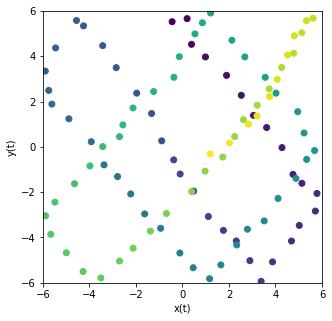

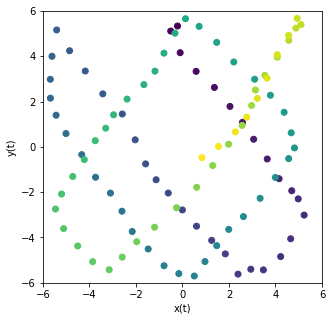

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)